In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Bidirectional, Dense, Conv1D, MaxPooling1D,GlobalAveragePooling1D, Concatenate, BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import numpy as np

In [4]:
import numpy as np
import pandas as pd
# Load the dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_30sec_Segmented.csv"
df = pd.read_csv(file_path)

# Show original data shape
print("Original shape:", df.shape)

# Define number of samples per segment (30 seconds worth)
samples_per_segment = 450

# Calculate the number of complete segments
n_segments = df.shape[0] // samples_per_segment
print(f"Total complete segments: {n_segments}")

# Trim dataset to only include complete segments
df_trimmed = df.iloc[:n_segments * samples_per_segment].copy()

# Assign segment IDs for grouping
df_trimmed['segment_id'] = np.repeat(np.arange(n_segments), samples_per_segment)

# Define feature columns (exclude segment_id)
feature_columns = df_trimmed.columns.difference(['segment_id'])

# Stack into 3D NumPy array: (segments, samples_per_segment, features)
X = np.stack([
    group[1][feature_columns].to_numpy()
    for group in df_trimmed.groupby('segment_id')
])

# Show shape of resulting array
print(f"Shape of X: {X.shape}") # Expected shape: (n_segments, 450, n_features)




Original shape: (109800, 8)
Total complete segments: 244
Shape of X: (244, 450, 7)


In [5]:
# Load the segmented file
df = pd.read_csv("C:\\Users\\ADWIN ADI\\Downloads\\MainData_30sec_Segmented.csv")  # or your path
print(df.columns)

Index(['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity', 'Sensor2_Temp',
       'Sensor2_Pressure', 'Sensor2_Humidity', 'segment_id', 'Label'],
      dtype='object')


In [6]:
print(df.columns.tolist())


['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity', 'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity', 'segment_id', 'Label']


In [7]:
print("Total segments:", df['segment_id'].nunique())
samples_per_segment = df['segment_id'].value_counts().unique()
print("Samples per segment:", samples_per_segment)

Total segments: 244
Samples per segment: [450]


In [8]:
import pandas as pd
import numpy as np

# Load your dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_30sec_Segmented.csv"
df = pd.read_csv(file_path)

# Confirm label column exists
print("Label column unique values:", df['Label'].unique())

# Define number of samples per segment
samples_per_segment = 450

# Calculate number of complete segments
n_samples = df.shape[0]
n_segments = int(n_samples // samples_per_segment)  # Ensure this is an int

print(f"Total complete segments: {n_segments}")

# Trim to full segments only
df_trimmed = df.iloc[:n_segments * samples_per_segment].copy()

# Create segment IDs
df_trimmed['segment_id'] = np.repeat(np.arange(n_segments), samples_per_segment)

# Copy label column properly
df_trimmed['Label'] = df['Label'].values[:n_segments * samples_per_segment]

# Exclude non-feature columns
feature_columns = df_trimmed.columns.difference(['segment_id', 'Label'])

# Reshape into (n_segments, 450, n_features)
X = np.stack([
    group[1][feature_columns].to_numpy()
    for group in df_trimmed.groupby('segment_id')
])

# Group labels per segment using mode
y = df_trimmed.groupby('segment_id')['Label'].agg(lambda x: x.mode()[0]).to_numpy()

print(f"\nX shape: {X.shape} (segments, 450 samples, {X.shape[2]} features)")
print(f"y shape: {y.shape} (segments)")
print("Labels:", np.unique(y))

Label column unique values: ['N' 'R' 'E']
Total complete segments: 244

X shape: (244, 450, 6) (segments, 450 samples, 6 features)
y shape: (244,) (segments)
Labels: ['E' 'N' 'R']


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Encoded y example:", y_encoded[:10])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Encoded y example: [1 1 1 1 1 1 1 1 1 1]
Label mapping: {'E': 0, 'N': 1, 'R': 2}


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)

In [11]:
def build_bilstm_branch(input_layer):
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = GlobalAveragePooling1D()(x)
    return x


In [12]:
def resnet_block(input_tensor, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same')(input_tensor)
    x = tf.keras.layers.add([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_resnet_branch(input_layer):
    x = resnet_block(input_layer, 64)
    x = resnet_block(x, 128)
    x = GlobalAveragePooling1D()(x)
    return x


In [13]:
def inception_module(input_tensor):
    conv1 = Conv1D(32, 1, padding='same', activation='relu')(input_tensor)
    conv3 = Conv1D(32, 3, padding='same', activation='relu')(input_tensor)
    conv5 = Conv1D(32, 5, padding='same', activation='relu')(input_tensor)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool = Conv1D(32, 1, padding='same', activation='relu')(pool)
    return Concatenate()([conv1, conv3, conv5, pool])

def build_inception_branch(input_layer):
    x = inception_module(input_layer)
    x = inception_module(x)
    x = GlobalAveragePooling1D()(x)
    return x


In [14]:
def build_combined_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Each branch
    bilstm_out = build_bilstm_branch(input_layer)
    resnet_out = build_resnet_branch(input_layer)
    inception_out = build_inception_branch(input_layer)

    # Combine
    combined = Concatenate()([bilstm_out, resnet_out, inception_out])
    x = Dropout(0.3)(combined)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [19]:
print("Actual column names in your CSV:")
print(df.columns.tolist())


Actual column names in your CSV:
['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity', 'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity', 'segment_id', 'Label']


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load the dataset
df = pd.read_csv("C:\\Users\\ADWIN ADI\\Downloads\\MainData_30sec_Segmented.csv")

# Define the feature columns (excluding 'Label' and 'segment_id' as features)
feature_cols = ['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
                'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity']

# Group data by segment_id and collect sequences and labels
X_list = []
y_list = []

for segment_id, group in df.groupby('segment_id'):
    X_list.append(group[feature_cols].values)               # Only features
    y_list.append(group['Label'].iloc[0])                    # Label per segment

# Convert to numpy arrays
X = np.stack(X_list)  # Shape: (samples, timesteps, features)
y = np.array(y_list)  # Shape: (samples,)

# Encode labels ('E', 'N', 'R') → (0, 1, 2)
label_encoder = LabelEncoder()
label_encoder.fit(['E', 'N', 'R'])         # Fixed label order
y_encoded = label_encoder.transform(y)     # Convert string labels to integers

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Output shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

# Optional: Show label mapping
print("Label classes (0, 1, 2):", label_encoder.classes_)


X_train shape: (195, 450, 6)
X_test shape: (49, 450, 6)
y_train_cat shape: (195, 3)
y_test_cat shape: (49, 3)
Label classes (0, 1, 2): ['E' 'N' 'R']


In [35]:
# Example usage:
input_shape = (450, 6)  # time_steps, num_features
num_classes = 3

model = build_combined_model(input_shape, num_classes)
model.summary()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=16
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 450, 6)]     0           []                               
                                                                                                  
 conv1d_14 (Conv1D)             (None, 450, 64)      1216        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 450, 64)     256         ['conv1d_14[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv1d_15 (Conv1D)             (None, 450, 64)      12352       ['batch_normalization_4[0][

In [36]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")


2/2 [==============================] - 0s 99ms/step - loss: 0.2207 - accuracy: 0.8367
Test Accuracy: 0.8367


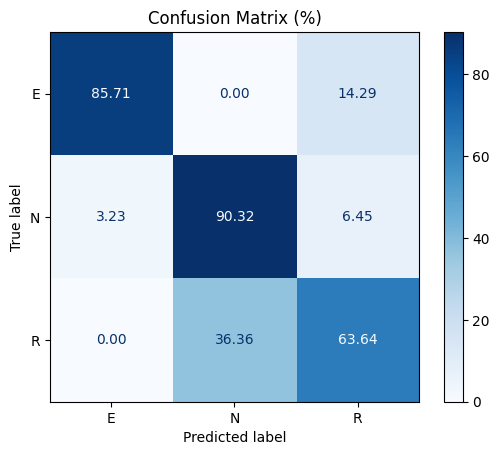

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict class labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix (raw)
cm = confusion_matrix(y_true, y_pred)

# Convert to percentage (normalize by rows = actual class counts)
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Round to two decimals
cm_percentage_rounded = np.round(cm_percentage, 2)

# Display percentage confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_rounded,
                              display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Confusion Matrix (%)")
plt.show()


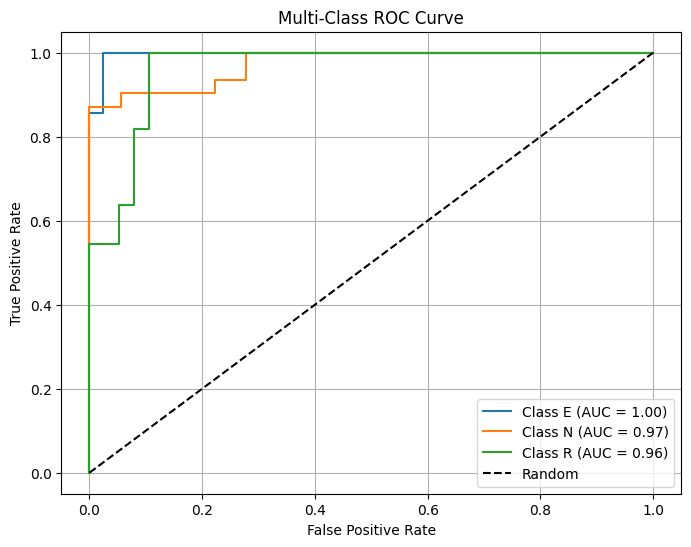

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels (already one-hot in y_test_cat)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Bidirectional, LSTM, Concatenate, MaxPooling1D
from tensorflow.keras.models import Model

# ---- ResNet1D Block ----
def resnet_block(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet1d_branch(input_layer):
    x = resnet_block(input_layer, filters=64, kernel_size=7)
    x = resnet_block(x, filters=128, kernel_size=5)
    x = resnet_block(x, filters=256, kernel_size=3)
    x = GlobalAveragePooling1D()(x)
    return x

# ---- BiLSTM Branch ----
def build_bilstm_branch(input_layer):
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = Bidirectional(LSTM(32))(x)
    return x

# ---- InceptionTime Block ----
def inception_module(inputs):
    conv1 = Conv1D(32, 1, padding='same', activation='relu')(inputs)
    conv3 = Conv1D(32, 3, padding='same', activation='relu')(inputs)
    conv5 = Conv1D(32, 5, padding='same', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(inputs)
    pool = Conv1D(32, 1, padding='same', activation='relu')(pool)
    return Concatenate()([conv1, conv3, conv5, pool])

def build_inception_branch(input_layer):
    x = inception_module(input_layer)
    x = inception_module(x)
    x = GlobalAveragePooling1D()(x)
    return x

# ---- Ensemble Model ----
def build_ensemble_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Branches
    resnet_output = build_resnet1d_branch(inputs)
    bilstm_output = build_bilstm_branch(inputs)
    inception_output = build_inception_branch(inputs)

    # Concatenate all features
    x = Concatenate()([resnet_output, bilstm_output, inception_output])
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [42]:
model = build_ensemble_model(input_shape=X.shape[1:], num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=50, batch_size=32)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 450, 6)]     0           []                               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 450, 64)      2752        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 450, 64)     256         ['conv1d_28[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 re_lu (ReLU)                   (None, 450, 64)      0           ['batch_normalization_8[0][

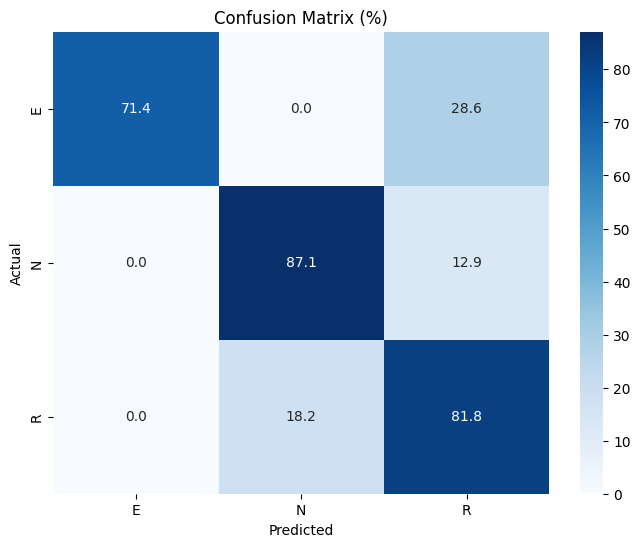

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()


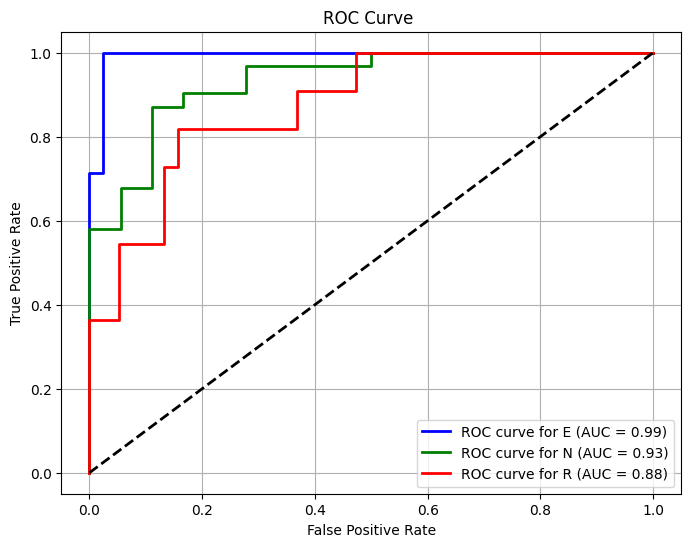

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = y_test_cat.shape[1]
y_score = model.predict(X_test)

# Binarize the output if not already
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


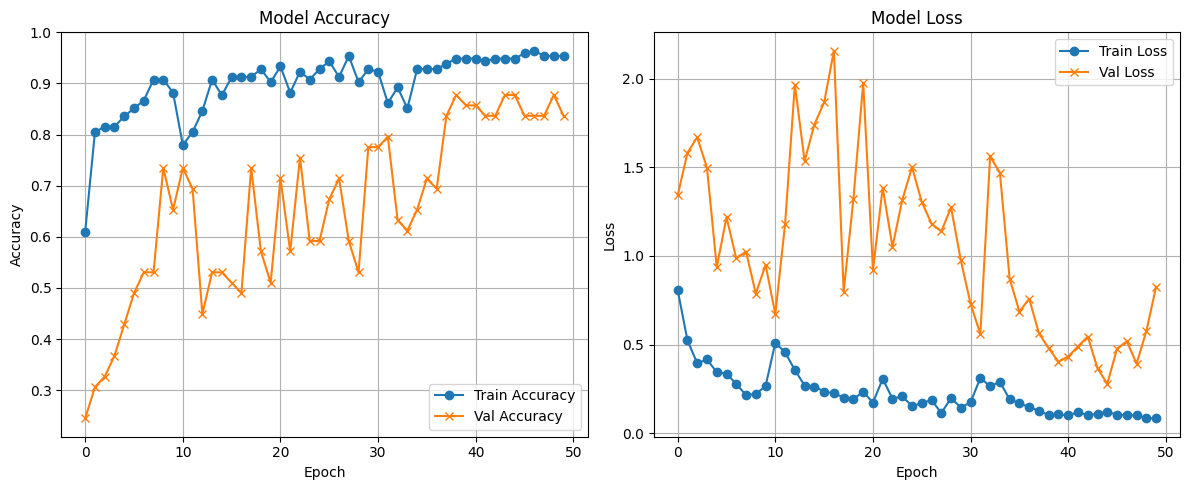

In [45]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [68]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime

# ------------------------- Load and Prepare Data -------------------------
# Load your preprocessed breathing data CSV
data = pd.read_csv("MainData_30sec_Segmented.csv")

# Features and Labels
X = data.drop('label', axis=1).values
y = data['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-validation split
X_train, X_val, y_train_cat, y_val_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Reshape for LSTM input: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# ------------------------- Build the Model -------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------------- Callbacks -------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# Generate a unique filename using timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
weights_path = f"best_breathing_model_{timestamp}.weights.h5"

checkpoint = ModelCheckpoint(
    weights_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# ------------------------- Training -------------------------
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[reduce_lr, checkpoint],
    verbose=1
)

# ------------------------- Evaluation -------------------------
y_val_pred = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val_cat, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels, target_names=le.classes_))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_val_true_labels, y_val_pred_labels))


FileNotFoundError: [Errno 2] No such file or directory: 'MainData_30sec_Segmented.csv'

In [49]:
model = build_best_breathing_model(input_shape=X.shape[1:], num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "CNN_BiLSTM_Transformer_Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 450, 6)]     0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 450, 64)      1984        ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 225, 64)     0           ['conv1d_45[0][0]']              
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 225, 128)    66048       ['max_pooling1d_6[0][0]']        
 )                                                                 